# Image Quilting

## Matthew Hallac & Saurav Shroff

In [347]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [439]:
import os
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from PIL import Image 
import cv2
from skimage.transform import rescale

In [451]:
# load images here
TEXTURE_1 = imread("text_small.jpg") / 255.
TEXTURE_2 = imread("bricks_small.jpg") / 255.
TEXTURE_3 = imread("white_small.jpg") / 255.

TARGET = rescale(imread("target.jpg") / 255., 0.4)
TARGET2 = imread("matt.jpg") / 255.

### Part 1: Randomly Sampled Texture

In [452]:
def quilt_random(sample, outsize, patchsize):
    assert len(outsize) == len(sample.shape)
    
    # init an empty output image and compute how many tiles we will need in each axis
    out = np.zeros(outsize)
    y_tiles = int(outsize[0] / patchsize)
    x_tiles = int(outsize[1] / patchsize)
    
    # define a list of positions we want to "tile" in our output image
    tile_positions = []
    for y in range(y_tiles):
        for x in range(x_tiles):
            tile_positions.append((y*patchsize, x*patchsize))
            
    # for each position we want to tile, randomly choose and copy a tile from SAMPLE
    for y, x in tile_positions:
        ry = randint(0, sample.shape[0] - patchsize)
        rx = randint(0, sample.shape[1] - patchsize)
        out[y:y+patchsize, x:x+patchsize, :] = sample[ry:ry+patchsize, rx:rx+patchsize, :]

    return out
        
        

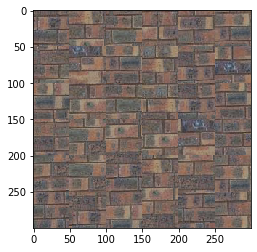

In [479]:
im_random = quilt_random(TEXTURE_2, (300,300, 3), 50)
# imsave("random_bricks.png", im_random)
imshow(im_random)

### Part 2: Overlapping Patches

In [453]:
# Helper functions 
def ssd(im1, im2):
    return np.sum(np.square(im1 - im2))

def choose_patch(current_patch, patches, tol):
    mask = (current_patch > 0).astype(int)
    current_patch = current_patch
    patch_scores = []
    for patch in patches:
        patch_eval = np.multiply(mask, patch)
        s = ssd(patch_eval, current_patch)
        patch_scores.append((s, patch))
    patch_scores.sort(key = lambda x: x[0])
    return patch_scores[randint(0, 100)][1]    

In [454]:
def quilt_simple(sample, outsize, patchsize, overlap, tol):
    assert len(outsize) == len(sample.shape)
    
    # init an empty output image and compute how many tiles we will need in each axis
    out = np.zeros(outsize).astype(float)
    y_tiles = 1 + int((outsize[0] - patchsize) / (patchsize - overlap))
    x_tiles = 1 + int((outsize[1] - patchsize) / (patchsize - overlap))
    
    # place the top left tile (choosing randomly)
    ry = randint(0, sample.shape[0] - patchsize)
    rx = randint(0, sample.shape[1] - patchsize)
    out[0:patchsize, 0:patchsize, :] = sample[ry:ry+patchsize, rx:rx+patchsize, :]
    
    # define a list of positions we want to "tile" in our output image
    tile_positions = []
    for y in range(y_tiles):
        for x in range(x_tiles):
            tile_positions.append((y*(patchsize - overlap) ,  x*(patchsize - overlap))) 
    
    patches = []
    for y in range(0, sample.shape[0] - patchsize):
        for x in range(0, sample.shape[1] - patchsize):
            patches.append(sample[y:y+patchsize, x:x+patchsize, :])
            
            
    # for each position we want to tile, choose and copy a tile from SAMPLE
    for y, x in tile_positions:
        if y == 0 and x == 0: continue
        current_patch = out[y:y+patchsize, x:x+patchsize, :]
        chosen_patch = choose_patch(current_patch, patches, tol)
        out[y:y+patchsize, x:x+patchsize, :] = chosen_patch        
        
    return out

In [ ]:
im = quilt_simple(TEXTURE_2, (300, 300, 3), 50, 25, 0.1)
imshow(im)

In [458]:
# imsave("quilted_bricks.png", im)

### Part 3: Seam Finding

In [ ]:
def cut(bndcost, ):
    
    
    

### Part 4: Texture transfer

In [446]:
# Helper functions 
TARGET_WEIGHT = 0.5 # must be between 0 and 1, defines how much we care about the target score

def choose_patch_texture(current_patch, patches, y, x, target, patchsize):
    mask = (current_patch > 0).astype(int)
    current_patch = current_patch
    patch_scores = []
    target_patch = target[y:y+patchsize, x:x+patchsize, :]
    for patch in patches:
        patch_eval = np.multiply(mask, patch)
        overlap_score = ssd(patch_eval, current_patch)        
        target_score = ssd(patch, target_patch)
        s = (target_score * TARGET_WEIGHT) + (overlap_score * (1 - TARGET_WEIGHT))
        patch_scores.append((s, patch))
    patch_scores.sort(key = lambda x: x[0])
    return patch_scores[randint(0, 100)][1] 

In [447]:
def texture_transfer(sample, target, patchsize, overlap, tol):
    outsize = target.shape
    assert len(outsize) == len(sample.shape)
    # init an empty output image and compute how many tiles we will need in each axis
    out = np.zeros(outsize).astype(float)
    y_tiles = 1 + int((outsize[0] - patchsize) / (patchsize - overlap))
    x_tiles = 1 + int((outsize[1] - patchsize) / (patchsize - overlap))
    
    # place the top left tile (choosing randomly)
    ry = randint(0, sample.shape[0] - patchsize)
    rx = randint(0, sample.shape[1] - patchsize)
    out[0:patchsize, 0:patchsize, :] = sample[ry:ry+patchsize, rx:rx+patchsize, :]
    
    # define a list of positions we want to "tile" in our output image
    tile_positions = []
    for y in range(y_tiles):
        for x in range(x_tiles):
            tile_positions.append((y*(patchsize - overlap) ,  x*(patchsize - overlap))) 
    
    patches = []
    for y in range(0, sample.shape[0] - patchsize):
        for x in range(0, sample.shape[1] - patchsize):
            patches.append(sample[y:y+patchsize, x:x+patchsize, :])
            
            
    # for each position we want to tile, choose and copy a tile from SAMPLE
    for y, x in tile_positions:
        if y == 0 and x == 0: continue
#         print(y, x)
        current_patch = out[y:y+patchsize, x:x+patchsize, :]
        chosen_patch = choose_patch_texture(current_patch, patches, y, x, target, patchsize)
        out[y:y+patchsize, x:x+patchsize, :] = chosen_patch
    
    return out

0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
10 0
10 10
10 20
10 30
10 40
10 50
10 60
10 70
10 80
10 90
10 100
10 110
10 120
10 130
10 140
10 150
10 160
10 170
10 180
20 0
20 10
20 20
20 30
20 40
20 50
20 60
20 70
20 80
20 90
20 100
20 110
20 120
20 130
20 140
20 150
20 160
20 170
20 180
30 0
30 10
30 20
30 30
30 40
30 50
30 60
30 70
30 80
30 90
30 100
30 110
30 120
30 130
30 140
30 150
30 160
30 170
30 180
40 0
40 10
40 20
40 30
40 40
40 50
40 60
40 70
40 80
40 90
40 100
40 110
40 120
40 130
40 140
40 150
40 160
40 170
40 180
50 0
50 10
50 20
50 30
50 40
50 50
50 60
50 70
50 80
50 90
50 100
50 110
50 120
50 130
50 140
50 150
50 160
50 170
50 180
60 0
60 10
60 20
60 30
60 40
60 50
60 60
60 70
60 80
60 90
60 100
60 110
60 120
60 130
60 140
60 150
60 160
60 170
60 180
70 0
70 10
70 20
70 30
70 40
70 50
70 60
70 70
70 80
70 90
70 100
70 110
70 120
70 130
70 140
70 150
70 160
70 170
70 180
80 0
80 10
80 20
80 30
80 40
80 50
80 60
80 70


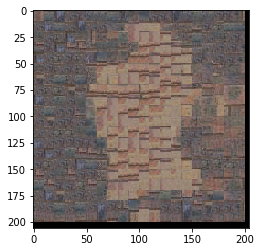

In [477]:
im_matt = texture_transfer(TEXTURE_2, TARGET, 20, 10, 0.1)
imshow(im_matt)

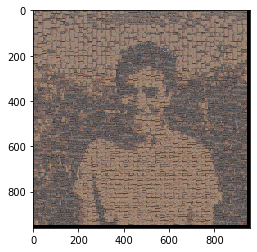

In [436]:
s = imread('saurav_out_of_bricks.png')
imshow(s)